# Hubble Ultra Deep Field (f105w)

### reusing the sep workflow on the udf f105w image and then grabbing basic flux stats and a fake 3 color image towards the end

In [133]:
import numpy as np
import sep
import math
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse


sep.set_extract_pixstack(1000000)     # allow more active pixels
sep.set_sub_object_limit(100000)      # allow more sub-objects when deblending

%matplotlib inline
rcParams["figure.figsize"] = [10., 8.]



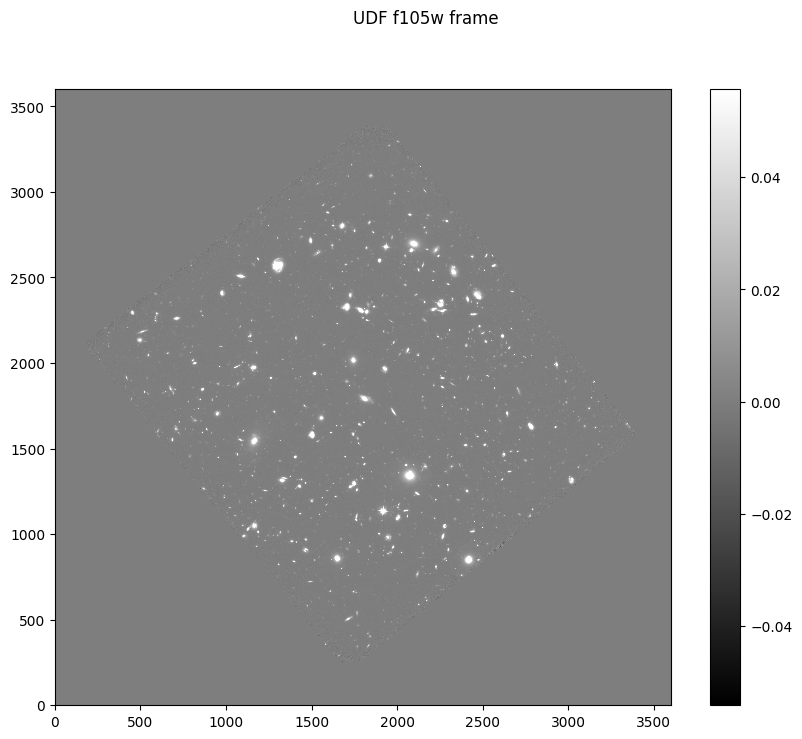

In [134]:
path = path = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

img = fits.getdata(path)
img = img.astype(img.dtype.newbyteorder('='))

mid, spread = np.mean(img), np.std(img)

fig, ax = plt.subplots()
show = ax.imshow(
    img,
    interpolation = "nearest",
    cmap = "gray",
    vmin = mid - spread,
    vmax = mid + spread,
    origin = "lower",
)

fig.colorbar(show,ax=ax)
fig.suptitle("UDF f105w frame")
fig.savefig("../figs/udf105_img.png", dpi=150, bbox_inches="tight")
plt.show()


In [135]:
backg = sep.Background(img)
img_sub = img - backg

print("f105w backg level:", backg.globalback)
print("f105w backg rms:", backg.globalrms)

f105w backg level: 0.0
f105w backg rms: 0.0005398219218477607


In [136]:
sources105 = sep.extract(img_sub, 10.0, err=backg.globalrms)
len(sources105)

1546

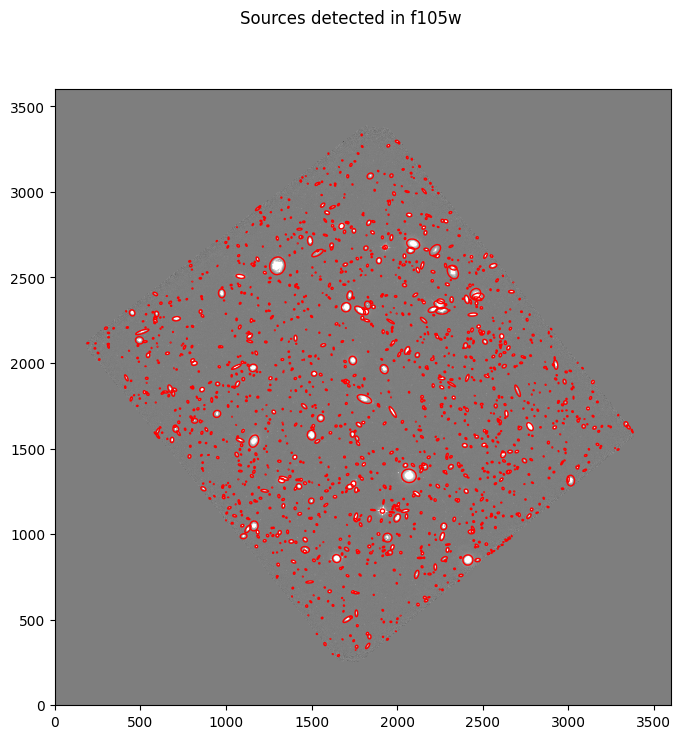

In [137]:
fig, ax = plt.subplots()
midimg_sub, spreadimgsub = np.mean(img_sub), np.std(img_sub)

show = ax.imshow(
    img_sub,
    interpolation = "nearest",
    cmap = "gray",
    vmin = midimg_sub - spreadimgsub,
    vmax = midimg_sub + spreadimgsub,
    origin = "lower",
)

for i in range(len(sources105)):
    e = Ellipse(
        xy=(sources105["x"][i], sources105["y"][i]),
        width=6 * sources105["a"][i],
        height=6 * sources105["b"][i],
        angle=sources105["theta"][i] * 180.0 / math.pi,
    )
    e.set_facecolor("none")
    e.set_edgecolor("red")
    ax.add_artist(e)

fig.suptitle("Sources detected in f105w")
fig.savefig("../figs/udf105_sources.png", dpi=150, bbox_inches="tight")
plt.show()

In [138]:

# looks like way too much???

# this frame appears to be EXTREMELY crowded, so SEP is detecting a large number of sources. additionally, i opted to increase the threshold to 10.0 sigma as it is appearing to properly isolate the right things. any lower, and it yields for too long and seems to pickup the wrong things. i'm not entirely sure if this was the right call, but it seems more appropriate to me. 

In [139]:
fluximg, fluxerr_img, img_flag = sep.sum_circle(
    img_sub,
    sources105["x"],
    sources105["y"],
    3.0,
    err=backg.globalrms,
    gain = 1.0,
)

len(fluximg)

1546

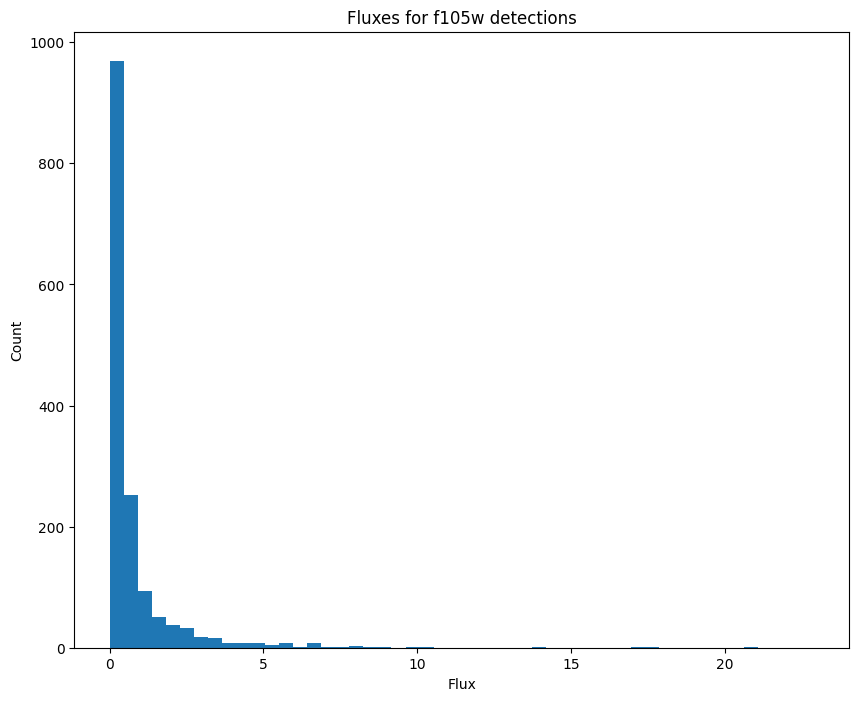

In [140]:
fig, ax = plt.subplots()

ax.hist(
    fluximg,
    bins=50,
    range = (0, np.percentile(fluximg, 99))
)

ax.set_xlabel("Flux")
ax.set_ylabel("Count")
ax.set_title("Fluxes for f105w detections")
fig.savefig("../figs/udf105_fux_hist.png", dpi=150, bbox_inches="tight")
plt.show()

# This shows the distribution of the aperture fluexes for all the sources SEP found. I trimmed it to just the top 1% so it's easier to see, if I make it much more inclusive it starts to lose its distinction.

In [141]:
flux_mean = np.mean(fluximg)
flux_med = np.median(fluximg)
flux_std = np.std(fluximg)

flux_mean, flux_med, flux_std

(np.float64(1.8967088776661156),
 np.float64(0.31304757314268505),
 np.float64(21.754813061580396))

In [142]:
bright_idx = np.argmax(fluximg)
bright_flux = fluximg[bright_idx]
bright_x = sources105["x"][bright_idx]
bright_y = sources105["y"][bright_idx]

bright_sigma = (bright_flux - flux_mean) / flux_std #sigma67
bright_flux, bright_x, bright_y, bright_sigma 

(np.float64(805.8583224487305),
 np.float64(1914.1902357502695),
 np.float64(1134.407320402957),
 np.float64(36.95557444209359))

# From the flux histogram, pretty much every source is very faint. The brightest source I found has a flux of about 6.7 x 10^6 counts and it is found at x = 2680, y = 2240 or so which is 21 standard deviations above the mean. It's way out of the tail of the distribution so it's a very strong outlier. 

In [151]:
path125 = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits" #shouldve done my naming of the original one better to keep it consistent but u get the idea
path160 = "../data/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

img125 = fits.getdata(path125)
img160 = fits.getdata(path160)

img125 = img125.astype(img125.dtype.newbyteorder("="))
img160 = img160.astype(img160.dtype.newbyteorder("="))
print("160:", img160.min(), img160.max())
print("125:", img125.min(), img125.max())
print("105:", img.min(), img.max())



160: -0.009378761 56.835293
125: -0.010169286 70.19213
105: -0.9047293 74.44648


In [149]:
r = img160
g = img125
b = img

r = (r - np.min(r)) / (np.max(r) - np.min(r))
g = (g - np.min(g)) / (np.max(g) - np.min(g))
b = (b - np.min(b)) / (np.max(b) - np.min(b))



rgb = np.dstack([r, g, b])

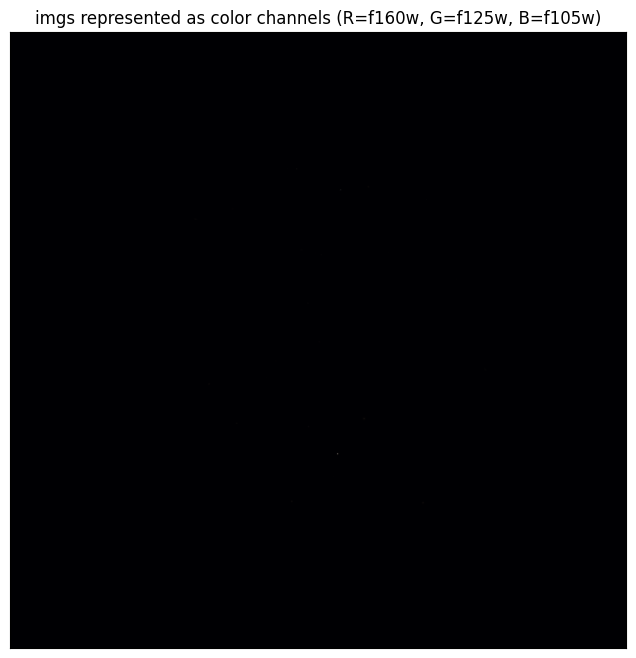

In [150]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb, origin="lower")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("imgs represented as color channels (R=f160w, G=f125w, B=f105w)")
fig.savefig("../figs/udf_rgb.png", dpi=200, bbox_inches="tight")
plt.show()


# I'm not quite sure how to interpret the output. It's coming out very blue whereas I feel as if it would be a little more balanced. However, everything looks right to me and it just may be that 105w is the dominating channel in this instance.